In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *
from click_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


data_dir    = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/'
participant = 'T5/historical/'
min_nblocks = 3

# preprocess by selecting sessions with a minimal block count:
files          = loadDataset(data_dir, participant)
click_sessions = get_Sessions(files, min_nblocks, getClick = True)

### train linear regression on day 0, get baseline performance measure


In [3]:
# Get initial day performance and decoder:
train_size = 0.67
task       = None
sigma      = 2
blocks     = None

day0       = DataStruct(click_sessions[0], alignScreens = True, causal_filter = sigma)

train_x, test_x, train_y, test_y  = getTrainTest(day0, train_size = train_size, sigma = sigma, task = task, blocks = blocks, returnFlattened = True)
train_x, test_x  = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
train_y          = np.concatenate(train_y)
test_y           = np.concatenate(test_y)
    
print('Performance on day 0: R^2 = ', LinearRegression().fit(train_x, train_y).score(test_x, test_y))

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Performance on day 0: R^2 =  0.3805815529526199


In [4]:
neural      = [day0.TX_continuous[:10000, :]]
cursorPos   = [day0.cursorPos_continuous[:10000, :]]
clickSignal = [day0.decClick_continuous[:10000]]
targetPos   = [day0.targetPos_continuous[:10000, :]]

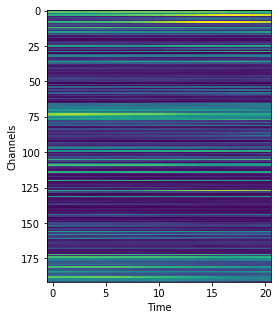

In [10]:
figSize(5, 4)

window       = 20

click_times  = np.where(clickSignal[0] == 1)[0][:-4]
n_clicks     = len(click_times)
neural_click = np.zeros((window  + 1, 192, n_clicks))

for i, t in enumerate(click_times):
    neural_click[:, :, i] = neural[0][(t - window):(t + 1), :]
avgd = np.mean(neural_click, axis = 2)


plt.imshow(avgd.T, aspect = 'auto')
plt.xlabel('Time')
plt.ylabel('Channels')
plt.show()

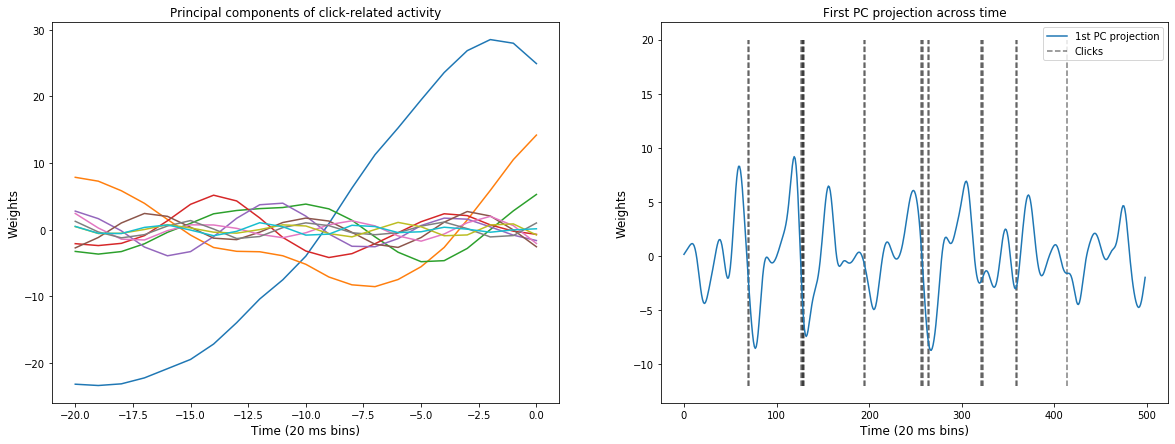

In [11]:
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
figSize(7, 20)

pca  = PCA().fit(avgd)

plt.subplot(1, 2, 1)
components = pca.transform(avgd)
plt.plot(np.arange(-1 * window, 1), components[:, :10])
plt.xlabel('Time (20 ms bins)', fontsize = 12)
plt.ylabel('Weights', fontsize = 12)
plt.title('Principal components of click-related activity', fontsize = 12)

plt.subplot(1, 2, 2)
timecourse = gaussian_filter1d((neural[0] - neural[0].mean(axis = 0)).dot(pca.components_[0, :]), sigma = 5)

plt.plot(np.diff(timecourse[:500]), label = '1st PC projection')
plt.vlines(click_times[:20], ymin = -12, ymax = 20, color = 'k', linestyle = '--', alpha = 0.5, label = 'Clicks')
plt.xlabel('Time (20 ms bins)', fontsize = 12)
plt.ylabel('Weights', fontsize = 12)
plt.title('First PC projection across time', fontsize = 12)
plt.legend()
plt.show()

In [13]:
from click_utils import get_WindowedFeatures, ClickDecoder
from sklearn.model_selection import train_test_split
import seaborn as sns

train_x, test_x, train_y, test_y = train_test_split(neural[0], clickSignal[0], train_size = 0.8, shuffle = False)


window       = 20
padding      = 0
n_components = 5

classifier = ClickDecoder(window, n_components).train(train_x, train_y)
probs      = classifier.predict_proba(test_x)[:, 1]

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


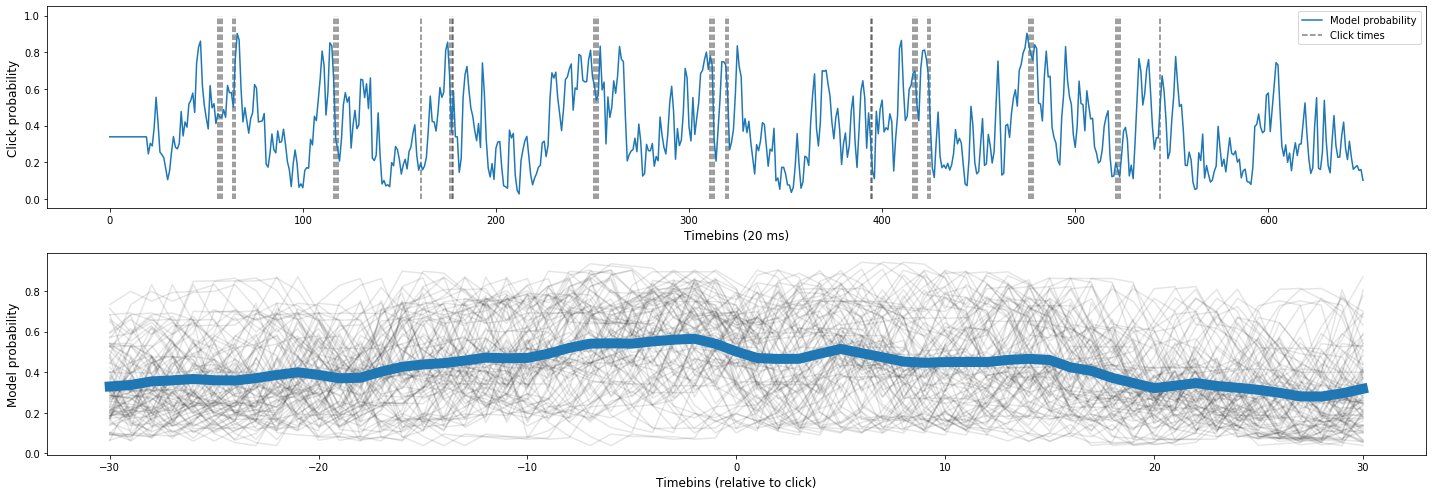

In [14]:
figSize(7, 20)


plt.subplot(2, 1, 1)
plt.plot(classifier.predict_proba(test_x)[:650, 1], label = 'Model probability')
plt.vlines(np.where(test_y == 1)[0][:34], ymin = 0, ymax = 1, color = 'k', linestyle = '--', alpha = 0.5, label = 'Click times')
plt.xlabel('Timebins (20 ms)', fontsize = 12)
plt.ylabel('Click probability', fontsize = 12)
plt.legend(loc = 'upper right')

plt.subplot(2, 1, 2)
view_window = 30

click_times = np.where([test_y == 1])[1]
click_times = click_times[np.logical_and(click_times > view_window, click_times < len(test_y) - view_window)]
click_probs = np.zeros((len(click_times), view_window * 2 + 1))

for i, t in enumerate(click_times):
    snippet           = probs[(t - view_window ):(t + view_window + 1 )]
    click_probs[i, :] = snippet 
    plt.plot(np.arange(-1 * view_window, view_window + 1), snippet, color = 'k', alpha = 0.1)
    
plt.plot(np.arange(-1 * view_window, view_window + 1), click_probs.mean(axis = 0), linewidth = 10)
plt.xlabel('Timebins (relative to click)', fontsize = 12)
plt.ylabel('Model probability', fontsize = 12)

plt.tight_layout()
plt.show()




/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


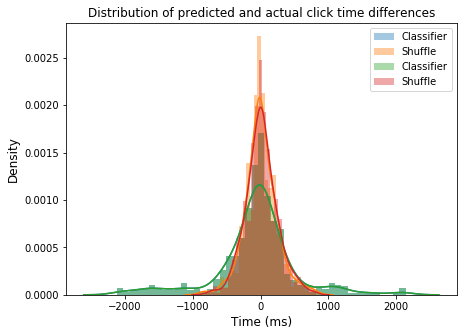

In [16]:
figSize(5, 7)

time_diffs = classifier.score_delta(test_x, test_y)

# wreck temporal structure but keep feature --> target pairings:
dummy_train_x, dummy_test_x, dummy_train_y, dummy_test_y = train_test_split(neural[0], clickSignal[0], train_size = 0.8, shuffle = True)
np.random.shuffle(dummy_train_x)
dummy        = ClickDecoder(window, n_components).train(dummy_train_x, dummy_train_y)
atemp_diffs  = dummy.score_delta(dummy_test_x, dummy_test_y)

# now destroy pairings too:
np.random.shuffle(dummy_train_x)
dummy        = ClickDecoder(window, n_components).train(dummy_train_x, dummy_train_y)
dummy_diffs  = dummy.score_delta(dummy_test_x, dummy_test_y)

sns.distplot(time_diffs * 20, label = 'Classifier')
sns.distplot(atemp_diffs * 20, label = 'Shuffle')
plt.xlabel('Time (ms)', fontsize = 12)
plt.ylabel('Density', fontsize = 12)
plt.legend()
plt.title('Distribution of predicted and actual click time differences', fontweight = 12)
plt.show()

In [ ]:
# Check how well our offline decoder aligns with the historic T5 click decoder's probabilities:

n_bins = 10


alldists     = np.linalg.norm(cursorPos[0] - targetPos[0], axis = 1) 
dist_bins    = np.linspace(0, alldists.max(), n_bins + 1)
click_probs  = np.zeros((n_bins,))
click_labels = np.zeros((n_bins,))
for j in range(len(dist_bins) - 1):
    bin_pts   = np.logical_and(alldists > dist_bins[j], alldists < dist_bins[j+1])  # all distance times within given discretized bin
    click_pts = np.logical_and(bin_pts, classifier.predict(neural[0]))

    click_probs[j]  = sum(click_pts) / sum(bin_pts)
    click_labels[j] = np.round((dist_bins[j] + dist_bins[j+1]) / 2, 2)

In [840]:
def f_online(x):
    '''Empirical click probabilities from historical T5 click decoders.'''
    x_mat         = np.vstack([x**i for i in range(5)])    
    coefs         = [ 0.00000000e+00, -1.33178954e-03,  5.05269183e-06, -6.29799392e-09, 2.57353522e-12]
    out           = x_mat.T.dot(coefs) + 0.13775515475153405
    out[x > 1000] = .12
    
    return out


def f_offline(x):
    '''Offline click decoder probabilities.'''
    out       = np.zeros((len(x)))
    probs     = np.asarray([0.19116757, 0.0750774 , 0.01515152, 0.00245098, 0.00128205, 0.00424328, 0.02962963, 0.19936958, 0.42319055, 0.4822335, 0.4822335])
    dist_bins = np.asarray([0.,  53.60806253, 107.21612507, 160.8241876 , 214.43225013, 268.04031266, 321.6483752 , 375.25643773, 428.86450026, 482.47256279, 536.08062533])
    for i in range(len(x)):
        val     = max(0.1, x[i])
        bin_idx = np.argmax(np.where(val > dist_bins)[0])
        out[i]  = probs[int(bin_idx)]
        
    return out 
        
        

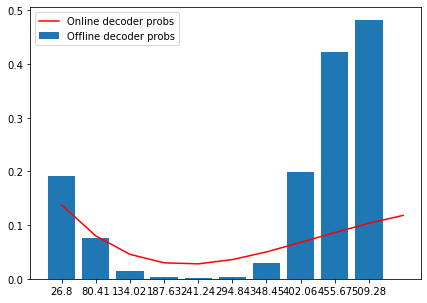

In [846]:
# Offline clearly a bit different than online as far as click probabilities:
# - this is motivation for defining an offline click observation model in click_HMM_T5.ipynb 

plt.bar(np.arange(len(click_probs)), click_probs, label = 'Offline decoder probs')
plt.xticks(np.arange(len(click_probs)), click_labels)


plt.plot(f_online(dist_bins),  color = 'r', label = 'Online decoder probs')
plt.legend()

## Click decoder decay dynamics

Now we'll look at click decoder stability across time, using pairs of sessions from the subselected click sessions we found earlier. Note that we have to deal with a couple of somewhat-off sessions:
- `D:/T5_ClosedLoop\t5.2016.10.13.mat` 
    - bad day; offline click decoder just fails (online seemed fine though?)
    - TOSS entire session
- `D:/T5_ClosedLoop\t5.2016.10.31.mat` 
    - has raw click decoder probabilities instead of thresholded predictions; also goes CLICK - NO CLICK - CLICK - NO CLICK
    - KEEP and convert probabilities to predictions; use the two click contiguous periods for train and test
- `D:/T5_ClosedLoop\t5.2016.10.24.mat` 
    - weird nonstationarity near end of trial (..neural? not a mean FR change)
    - KEEP; chop out end of trial to avoid nonstationarity

In [689]:
sessions_check = np.load('misc_data/sessions_check.npy', allow_pickle = True).item()
sessions_check['bad_days'].append('D:/T5_ClosedLoop\\t5.2016.10.13.mat')                # drop bad click decoder day

min_nblocks    = 3
max_ndays      = 1e23
min_R2         = 0.1


click_sessions = get_ClickSessions(files, min_nblocks = min_nblocks)  
init_pairs     = get_SessionPairs(click_sessions, max_ndays = max_ndays, manually_remove = sessions_check['bad_days'])
pairs, scores  = get_StrongTransferPairs(init_pairs, min_R2 = min_R2, train_frac = 0.5, block_constraints = sessions_check)
n_pairs        = len(pairs)

In [691]:
# Settings
window       = 20
n_components = 5
train_frac   = 0.8


days_between = np.zeros((n_pairs, ))
scores       = np.zeros((n_pairs, 3))  # column 1: train A/ test A; column 2: train B/ test B; column 3: train A/ test B

for i, pair in enumerate(pairs):
    
    # Get initial day performance and decoder:
    dayA            = DataStruct(pair[0], alignScreens = True)
    dayB            = DataStruct(pair[1], alignScreens = True)
    days_between[i] = daysBetween(dayA.date, dayB.date)
    
    Atrain_x, Atest_x, Atrain_y, Atest_y = get_T5_ClickTrainTest(dayA, train_frac = train_frac)
    Btrain_x, Btest_x, Btrain_y, Btest_y = get_T5_ClickTrainTest(dayB, train_frac = train_frac)
        

    Aclassifier  = ClickDecoder(window, n_components).train(Atrain_x - Atrain_x.mean(axis = 0), Atrain_y)
    Bclassifier  = ClickDecoder(window, n_components).train(Btrain_x - Btrain_x.mean(axis = 0), Btrain_y)
    
    scores[i, 0] = np.var(Aclassifier.score_delta(Atest_x - Atrain_x.mean(axis = 0), Atest_y))  # train A, test A
    scores[i, 1] = np.var(Bclassifier.score_delta(Btest_x - Btrain_x.mean(axis = 0), Btest_y))  # train B, test B
    scores[i, 2] = np.var(Aclassifier.score_delta(Btest_x - Btrain_x.mean(axis = 0), Btest_y))  # train A, test B (transfer)
    

Text(0.5, 1.0, 'Click decoder transfer performance')

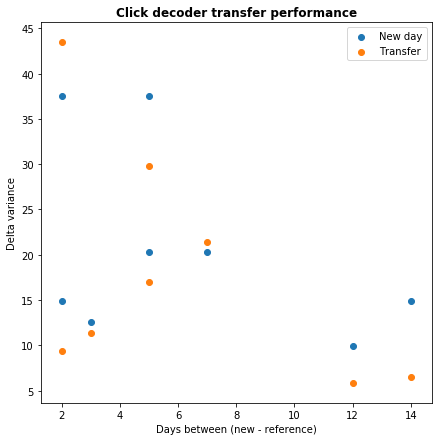

In [692]:
figSize(7, 7)

plt.scatter(days_between, scores[:, 1], label = 'New day')
plt.scatter(days_between, scores[:, 2], label = 'Transfer')
plt.xlabel('Days between (new - reference)')
plt.ylabel('Delta variance')
plt.legend()
plt.title('Click decoder transfer performance', fontweight = 'bold')

### Figure out what's up with bad click days

In [ ]:
bad_days = np.unique([pairs[i][1] for i in np.where(scores[:, 1] > 100)[0]])
print('Bad days: ', bad_days)

Session:  D:/T5_ClosedLoop\t5.2016.10.31.mat
Block list:  [3 5 6 7 8 9]


C:\Users\ghwilson\Anaconda3\envs\Speech\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Neural signals across session')

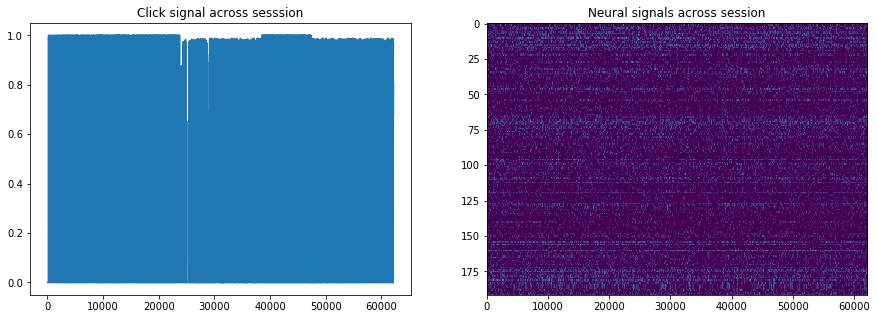

In [665]:
figSize(5, 15)

i = 0

print('Session: ', bad_days[i])
dat = DataStruct(bad_days[i])
print('Block list: ', dat.blockList) 

plt.subplot(1, 2, 1)
plt.plot(dat.decClick_continuous)
plt.title('Click signal across sesssion')
plt.subplot(1, 2, 2)
_ = plt.imshow(dat.TX_continuous.T, aspect = 'auto')
plt.title('Neural signals across session')

In [ ]:
from lineplots import comparisonScatterPlot
figSize(5, 10)

window       = 20
pca_window   = 100
n_components = 100

train_x, test_x, train_y, test_y = get_T5_ClickTrainTest(dat, train_frac)

classifier   = ClickDecoder(window, n_components, pca_window).train(train_x - train_x.mean(axis = 0), train_y)
train_score  = np.var(classifier.score_delta(train_x - train_x.mean(axis = 0), train_y))
test_score   = np.var(classifier.score_delta(test_x - train_x.mean(axis = 0), test_y))

print('Train delta score: ', train_score)
print('Test delta score: ', test_score)

plt.subplot(1, 2, 1)

comparisonScatterPlot(test_x.mean(axis = 0), train_x.mean(axis = 0))
plt.xlabel('Mean FR (train)')
plt.ylabel('Mean FR (test)')

plt.subplot(1, 2, 2)

win_size      = 5000
skip          = 250
rolling_score = list()

for i in range(0, len(dat.decClick_continuous), skip):
    neural       = dat.TX_continuous[i:(i + win_size), :]
    click        = dat.decClick_continuous[i:(i + win_size)]
    
    rolling_score.append(np.var(classifier.score_delta(neural - train_x.mean(axis = 0), click)))
plt.plot(np.arange(0, len(dat.decClick_continuous), skip), rolling_score)
plt.xlabel('Time')
plt.ylabel('Delta score')

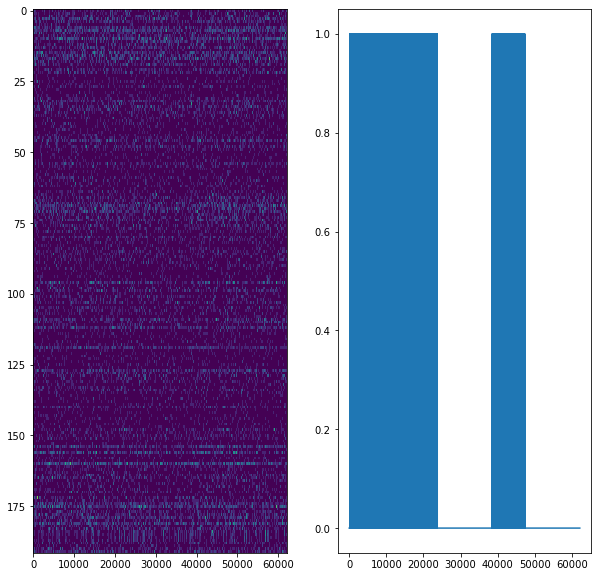

In [660]:
stretch = [60000, 75000]

plt.subplot(1, 2, 1)
_ = plt.imshow(dat.TX_continuous.T, aspect = 'auto')
plt.subplot(1, 2, 2)
_ = plt.plot(dat.decClick_continuous, )